# CSCI 4022 Project
## Community-Clustering Sports Betting 
Eddie Kiernan

## Data
Data comes from a study from the Transparency Project, a Division on Addiction, The Cambridge Health Alliance, a Harvard Medical School teaching hospital. The study description is as follows: "Daily fantasy sports (DFS), a rapidly growing industry, allows players to create fantasy teams of real-life players and potentially win cash prizes, derived from entry
fees. Some stakeholders have expressed concern that DFS's accelerated nature and other features might promote excessive play and related harm. We conducted the first descriptive summary of actual DFS play using records from a cohort of subscribers to a dominant operator, DraftKings. The data consists of 10,385 players who enrolled and made their initial deposits between August 1, 2014 and September 30, 2014, and entered at least one paid National Football League (NFL) contest." Of the data from the study we will be using the TacklingData5All.csv and TacklingData6Play.csv datasets, containing the metrics for players' entries into NFL-based contests, nonNFL-based contests, and all contests and the types of contests the players
entered, both in terms of sport and payout structure respectively.

In [1]:
import numpy as np
import pandas as pd
# below libraries for visualization/plotting purposes
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import networkx as nx
from itertools import combinations

In [2]:
df_all=pd.read_csv('TacklingData5All.csv')
df_all

,Date1st,DateLst,nDays,nCont,nEntries,nLineups,TotFees,AvgBuyIn,TotWinnings,nUserUp,UserID
0,2014-08-28,2015-01-25,3,3,3,3,31.00,10.333333,0.00,0,1
1,2014-09-07,2015-01-25,22,35,35,35,23.50,0.671429,19.25,9,2
2,2014-09-21,2015-01-25,23,39,52,52,1479.00,37.051282,1278.50,15,3
3,2014-09-07,2015-01-25,24,342,355,348,1468.75,4.277778,1399.89,117,4
4,2014-09-28,2015-01-25,12,22,22,22,85.00,3.863636,76.80,10,5
...,...,...,...,...,...,...,...,...,...,...,...
10380,2014-10-02,2015-01-25,26,87,146,87,144.25,0.997126,109.44,39,12036
10381,2014-10-02,2015-01-25,46,193,261,259,6736.84,25.698653,4867.40,46,12038
10382,2014-10-05,2014-10-05,1,1,1,1,27.00,27.000000,0.00,0,12039
10383,2014-10-05,2015-01-25,31,183,317,316,3885.92,13.261858,2357.84,49,12040


In [3]:
df_playtype=pd.read_csv('TacklingData6Play.csv')
df_playtype

,UserID,DidNFL,DidNBA,DidOth,Cnt1,Cnt2,Cnt3,Cnt4,Cnt5,Cnt6
0,1,True,True,True,0,0,0,0,1,2
1,2,True,False,True,2,0,0,0,0,33
2,3,True,True,True,27,4,0,1,1,6
3,4,True,False,True,137,92,16,19,31,47
4,5,True,False,False,9,0,12,0,0,1
...,...,...,...,...,...,...,...,...,...,...
10380,12036,True,True,True,62,1,0,9,0,15
10381,12038,True,True,True,22,26,8,4,30,103
10382,12039,True,False,False,0,0,0,0,0,1
10383,12040,True,False,True,1,0,0,2,4,176


In [4]:
df_playtype['DidNFL'].value_counts()

DidNFL
True    10385
Name: count, dtype: int64

In [5]:
# drop 'DidNFL' since all users particated in NFL league plays
df_playtype = df_playtype.drop('DidNFL', axis=1)
df_playtype.head()

,UserID,DidNBA,DidOth,Cnt1,Cnt2,Cnt3,Cnt4,Cnt5,Cnt6
0,1,True,True,0,0,0,0,1,2
1,2,False,True,2,0,0,0,0,33
2,3,True,True,27,4,0,1,1,6
3,4,False,True,137,92,16,19,31,47
4,5,False,False,9,0,12,0,0,1


## Code
First k-means will be used to cluster users into gambling archetypes with the TacklingData5All.csv data. Then once clustered, use community detection algorithm BigCLAM with the TacklingData6Play.csv data to connect users to community based on playing interests (played NBA, Other, or one of the Contests). Finally, cross-analyze both results to derive insights

### Clustering: K-Means

In [6]:
# Standard Scaler class 
# Simple scalar meant to preprocess data before running in KMeans
class Scaler:
    def fit(self, X):
        self.mean = np.mean(X, axis=0)
        self.std = np.std(X, axis=0)
        return self

    def transform(self, X):
        return (X - self.mean) / self.std

In [7]:
# KMeans Clustering class
# KMeans clustering based off scikit learn implementation
# https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
# https://github.com/scikit-learn/scikit-learn/blob/main/sklearn/cluster/_kmeans.py
class KMeans:
    def __init__(self, n_clusters=5, max_iter=500, tol=1e-4, random_state=None):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.tol = tol
        self.random_state = random_state

    def fit(self, X):  
        if self.random_state:
            np.random.seed(self.random_state)

        # randomly choose k points as initial centroids
        n_samples, n_features = X.shape
        random_indices = np.random.choice(n_samples, self.n_clusters, replace=False)
        self.centroids = X[random_indices]

        for _ in range(self.max_iter):
            # assign clusters
            distances = np.linalg.norm(X[:, np.newaxis] - self.centroids, axis=2)
            self.labels = np.argmin(distances, axis=1)

            # recompute centroids
            new_centroids = np.array([
                X[self.labels == i].mean(axis=0) if np.any(self.labels == i) else self.centroids[i]
                for i in range(self.n_clusters)
            ])

            # check for conv with tol
            if np.all(np.abs(new_centroids - self.centroids) < self.tol):
                break

            self.centroids = new_centroids

        return self

    def predict(self, X):
        distances = np.linalg.norm(X[:, np.newaxis] - self.centroids, axis=2)
        return np.argmin(distances, axis=1)

In [8]:
# Principle Component Anaysis (PCA)
# Used to reduce dimensionality to view clusters (2D projection) when using multiple features (>2)
# https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html
class PCA:
    def __init__(self, n_components):
        self.n_components = n_components

    def fit(self, X):
        # center the data
        self.mean = np.mean(X, axis=0)
        X_centered = X - self.mean

        # cov matrix
        cov_matrix = np.cov(X_centered, rowvar=False)

        # eigen decomp
        eig_vals, eig_vecs = np.linalg.eigh(cov_matrix)

        # sort by largest eigenvals
        sorted_idx = np.argsort(eig_vals)[::-1]
        self.components = eig_vecs[:, sorted_idx[:self.n_components]]

        return self

    def transform(self, X):
        X_centered = X - self.mean
        return np.dot(X_centered, self.components)

Below we use within cluster sum of squares for error calculation. The equation is given as:
$$WCSS = \sum_{i \in n}(X_i-Y_i)^2$$

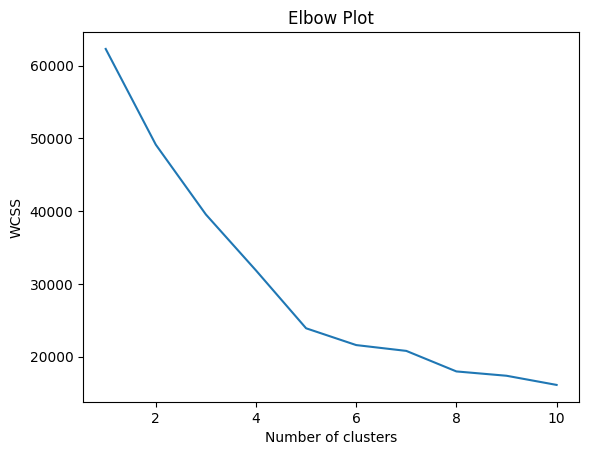

In [9]:
# features we will use for clustering
features = ['nDays', 'nCont', 'nEntries', 'TotFees', 'AvgBuyIn', 'TotWinnings']
X = df_all[features]

scaler = Scaler()
scaler.fit(X)
X_scaled = scaler.transform(X)
X_scaled_np = X_scaled.to_numpy() 

# within cluster sum of squares used for error calculation
# want to minimize
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(X_scaled_np)
    wcss.append(np.sum(np.min(np.linalg.norm(X_scaled_np[:, np.newaxis] - kmeans.centroids, axis=2), axis=1)**2))

plt.plot(range(1, 11), wcss)
plt.title('Elbow Plot')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [10]:
# elbow start at 5, so 5,6,7 all resonable choices for k
k = 6
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(X_scaled_np)
clusters = kmeans.predict(X_scaled_np)

df_all['Cluster'] = clusters

cluster_profile = df_all.groupby('Cluster')[features].mean()
cluster_profile

,nDays,nCont,nEntries,TotFees,AvgBuyIn,TotWinnings
Cluster,,,,,,
0,64.130108,225.201001,327.057548,1444.286756,5.218119,1165.650842
1,93.464286,1945.178571,3375.392857,17122.866071,5.511302,16491.540714
2,12.000000,37.250000,40.000000,23912.247500,785.083773,16949.500000
3,11.553679,27.277991,32.750082,205.849739,6.839187,137.501804
4,73.666667,327.242424,591.181818,26362.224242,102.713018,26842.247576
5,40.500000,2073.000000,2182.500000,173130.875000,66.380002,675039.950000


In [11]:
df_cluster = df_all
df_cluster.head()

,Date1st,DateLst,nDays,nCont,nEntries,nLineups,TotFees,AvgBuyIn,TotWinnings,nUserUp,UserID,Cluster
0,2014-08-28,2015-01-25,3,3,3,3,31.00,10.333333,0.00,0,1,3
1,2014-09-07,2015-01-25,22,35,35,35,23.50,0.671429,19.25,9,2,3
2,2014-09-21,2015-01-25,23,39,52,52,1479.00,37.051282,1278.50,15,3,3
3,2014-09-07,2015-01-25,24,342,355,348,1468.75,4.277778,1399.89,117,4,0
4,2014-09-28,2015-01-25,12,22,22,22,85.00,3.863636,76.80,10,5,3


In [12]:
df_cluster["Cluster"].value_counts()

Cluster
3    9119
0    1199
4      33
1      28
2       4
5       2
Name: count, dtype: int64

In [13]:
sampled_df = pd.DataFrame()

for i in range(k):
    single_cluster_df = df_cluster[df_cluster["Cluster"] == i]
    if single_cluster_df.shape[0] < 200:
        sampled_df = pd.concat([sampled_df, single_cluster_df], ignore_index=True)
    else:
        sampled_sample = single_cluster_df.sample(n=100, random_state=42)
        sampled_df = pd.concat([sampled_df, sampled_sample], ignore_index=True)

sampled_df.head()

,Date1st,DateLst,nDays,nCont,nEntries,nLineups,TotFees,AvgBuyIn,TotWinnings,nUserUp,UserID,Cluster
0,2014-09-29,2015-01-25,61,92,203,202,444.25,2.396739,279.33,21,11840,0
1,2014-09-18,2015-01-25,47,636,636,636,964.00,1.515723,1017.67,368,8478,0
2,2014-08-22,2014-11-09,42,204,227,215,1680.50,7.450980,1538.65,46,721,0
3,2014-08-30,2015-01-25,63,175,231,230,2856.50,10.927143,1802.60,30,4251,0
4,2014-09-07,2015-01-25,65,292,357,342,1717.00,5.041952,1830.37,62,395,0


In [14]:
# use PCA to reduce dimensionality to 2
pca = PCA(n_components=2)
pca.fit(X_scaled_np)
principal_components = pca.transform(X_scaled_np)
df_pca = pd.DataFrame(principal_components, columns=['PC1', 'PC2'])
df_pca['Cluster'] = clusters
df_pca.head()

,PC1,PC2,Cluster
0,0.699678,0.360023,3
1,0.182710,-0.267973,3
2,-0.188790,0.992522,3
3,-1.868829,-0.610758,0
4,0.432000,0.008033,3


In [15]:
pca_scaler = Scaler()
df_pca_scaled = df_pca.copy()
pca_scaler.fit(df_pca_scaled[['PC1', 'PC2']])
df_pca_scaled[['PC1', 'PC2']] = pca_scaler.transform(df_pca_scaled[['PC1', 'PC2']])

Description of below archetypes:  
 
 * Casual - Infrequent betters who bet small ammounts. Likely only bet in certain social occasion or during big events (SuperBowl, Master's, NBA Playoffs, etc). Winning is as expected, not winning or losing a subtantial ammount of money. More successful than One-time betters.
 * Low Roller - Very frequent betters who bet small ammounts. Despite betting small ammounts, win a large ammount of the time. Likely veyr analytical, experienced, and tactical betters. Most successful better on average.
 * Problem - Bet and lose very large ammounts of money. Bet very infrequently. Likely very wealthy individuals looking to make large bets during big events (SuperBowl) or a relapsing gambling addict.
 * One-time - Infrequent betters who bet small ammounts, only one-two times per year. Likely only betting during big social events (SuperBowl) paired with promotions.
 * Serious - Very frequent betters, betting substantial ammounts of money. Not winning or losing a subtantial ammount of money, but more successful than One-time and Casual betters.
 * High Roller - Bets a lot of money, wins a lot of money, fairly frequently. Very rare, most successful in terms of total winnings.

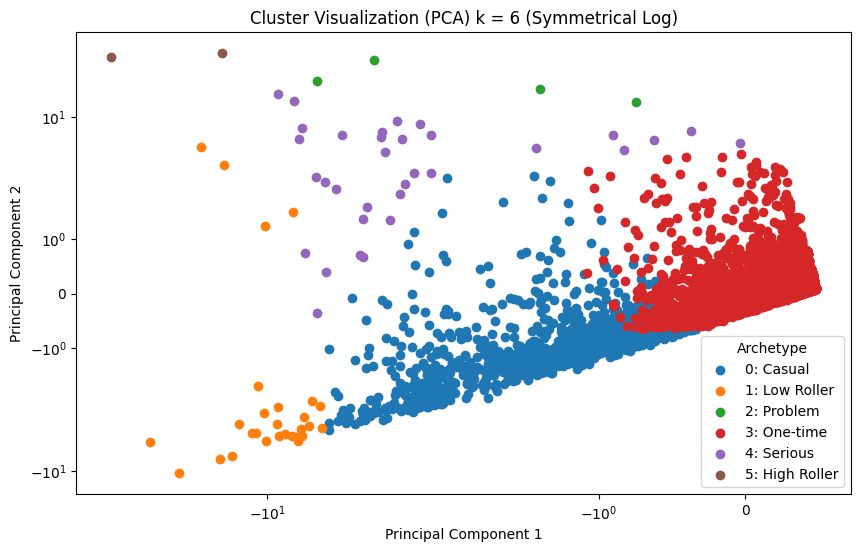

In [16]:
cluster_labels = {
    0: '0: Casual',
    1: '1: Low Roller',
    2: '2: Problem',
    3: '3: One-time',
    4: '4: Serious',
    5: '5: High Roller'
}

plt.figure(figsize=(10,6))
plt.yscale('symlog') # Use symlog to scale plot down and make more readable
plt.xscale('symlog')
for cluster_num, label in cluster_labels.items():
    subset = df_pca_scaled[df_pca['Cluster'] == cluster_num]
    plt.scatter(subset['PC1'], subset['PC2'], label=label)

plt.title(f'Cluster Visualization (PCA) k = {k} (Symmetrical Log)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Archetype')

### Community: BigCLAM

In [17]:
# BigCLAM
# https://github.com/snap-stanford/snap/tree/master/examples/bigclam
class BigCLAM:
    def __init__(self, num_communities, learn_rate=0.01, iterations=100):
        self.n_communities = num_communities
        self.lr = learn_rate
        self.iterations = iterations
        self.F = None
        self.neighbors = None

    def sigmoid(self, x):
        return np.exp(-x) / (1 - np.exp(-x) + 1e-10)

    def build_neighbor_lookup(self, A, sim_thresh=0.01):
        N = A.shape[0]
        neighbors = [list(np.where(A[i] > sim_thresh)[0]) for i in range(N)]
        return neighbors

    def gradient(self, A, i, neighbors_i):
        N, C = self.F.shape
        grad = np.zeros(C)

        for j in neighbors_i:
            if i == j:
                continue
            dot = self.F[i] @ self.F[j]
            grad += A[i, j] * self.F[j] * self.sigmoid(dot)

        # sum over all nodes minus neighbors
        grad -= self.F.sum(axis=0) - np.sum(self.F[neighbors_i], axis=0)
        return grad

    def log_likelihood(self, A):
        A_soft = self.F @ self.F.T
        np.fill_diagonal(A_soft, 0)

        A_soft = np.clip(A_soft, 1e-10, 100)  # avoid overflow
        
        x = A * np.log(1 - np.exp(-A_soft) + 1e-10)
        y = (1 - A) * A_soft
        return np.sum(x) - np.sum(y)

    def fit(self, A, sim_thresh=0.01):
        A = A.copy()
        N = A.shape[0]
        #self.F = np.random.rand(N, self.n_communities)  # original init
        self.F = np.abs(np.random.normal(loc=0.1, scale=0.01, size=(N, self.n_communities))) # better init
        self.neighbors = self.build_neighbor_lookup(A, sim_thresh)

        for step in range(self.iterations):
            for i in range(N):
                grad = self.gradient(A, i, self.neighbors[i])
                self.F[i] += self.lr * grad
                self.F[i] = np.maximum(1e-5, self.F[i])  # nonnegativity constraint

            if step % 5 == 0:
                ll = self.log_likelihood(A)
                print(f"Step {step}/{self.iterations} Log-Likelihood: {ll:.4f}")

        return self.F

    def get_communities(self, threshold=0.1):
        # return overlapping communities that are F[i, c] > threshold
        communities = {c: [] for c in range(self.n_communities)}
        for i, row in enumerate(self.F):
            for c, val in enumerate(row):
                if val > threshold:
                    communities[c].append(i)
        return communities


In [18]:
# Two cosine similarity functions. One for a single dataframes/matrix, other for a vector and a matrix
def cosine_similarity_df(X):
    if isinstance(X, pd.DataFrame):
        X = X.select_dtypes(include=[np.number]).astype(np.float64).to_numpy()
    else:
        X = np.asarray(X, dtype=np.float64)

    sim = X @ X.T
    norm = np.linalg.norm(X, axis=1)
    norm_matrix = np.outer(norm, norm)

    with np.errstate(invalid='ignore', divide='ignore'):
        sim = sim / norm_matrix
        sim[np.isnan(sim)] = 0

    return sim

def cosine_similarity_vect_matrix(mat, vec):
    vec = vec.flatten()
    return np.dot(mat, vec) / (np.linalg.norm(mat, axis=1) * np.linalg.norm(vec) + 1e-10)

In [19]:
small_df_playtype = df_playtype[df_playtype["UserID"].isin(sampled_df["UserID"])]
small_df_playtype.head()

,UserID,DidNBA,DidOth,Cnt1,Cnt2,Cnt3,Cnt4,Cnt5,Cnt6
113,129,False,False,2,3,1,0,2,2
152,170,True,True,0,0,4,6,0,393
199,223,True,False,123,28,4,1,1,59
269,302,True,True,2118,393,477,73,0,183
283,319,True,False,102,56,12,16,0,152


In [20]:
# choose contests columns
contest_cols = ['Cnt1', 'Cnt2', 'Cnt3', 'Cnt4', 'Cnt5', 'Cnt6']
small_df_playtype_ratio = small_df_playtype.copy()
small_df_playtype_ratio['TotalCnt'] = small_df_playtype_ratio[contest_cols].sum(axis=1)

# normalize contest columns
for col in contest_cols:
    small_df_playtype_ratio[f'{col}_Norm'] = small_df_playtype_ratio[col] / small_df_playtype_ratio['TotalCnt']

# new df w/ contests columns
small_df_playtype_ratio['DidNBA'] = small_df_playtype_ratio['DidNBA'].astype(float)
small_df_playtype_ratio['DidOth'] = small_df_playtype_ratio['DidOth'].astype(float)
small_df_playtype_ratio = small_df_playtype_ratio.drop(contest_cols, axis=1)
small_df_playtype_ratio = small_df_playtype_ratio.drop(['TotalCnt'], axis=1)
small_df_playtype_ratio.head()

,UserID,DidNBA,DidOth,Cnt1_Norm,Cnt2_Norm,Cnt3_Norm,Cnt4_Norm,Cnt5_Norm,Cnt6_Norm
113,129,0.0,0.0,0.200000,0.300000,0.100000,0.000000,0.20000,0.200000
152,170,1.0,1.0,0.000000,0.000000,0.009926,0.014888,0.00000,0.975186
199,223,1.0,0.0,0.569444,0.129630,0.018519,0.004630,0.00463,0.273148
269,302,1.0,1.0,0.652898,0.121147,0.147041,0.022503,0.00000,0.056412
283,319,1.0,0.0,0.301775,0.165680,0.035503,0.047337,0.00000,0.449704


In [21]:
# get sim matrix w/ cosine sim
small_user_features_ratio = small_df_playtype_ratio.set_index("UserID")
sim_matrix_ratio = cosine_similarity_df(small_user_features_ratio)
# fill diagrons w/ 0 since all 1 (user to same user)
np.fill_diagonal(sim_matrix_ratio, 0)

In [22]:
# want density in the [0.01, 0.1] range For BigCLAM. Sparse, but connected
adj_matrix_ratio = (sim_matrix_ratio > 0.99).astype(float)
density = adj_matrix_ratio.sum() / (adj_matrix_ratio.shape[0]**2)
print(f"Graph density: {density:.4f}")

Graph density: 0.0834


In [23]:
# need to be careful with learn_rate. To big and gradiant can explode
big_clam = BigCLAM(num_communities=5, learn_rate=3e-4, iterations=500) 
F = big_clam.fit(adj_matrix_ratio) 

Step 0/500 Log-Likelihood: -18977.0050
Step 5/500 Log-Likelihood: -14611.0438
Step 10/500 Log-Likelihood: -12356.4583
Step 15/500 Log-Likelihood: -11387.3165
Step 20/500 Log-Likelihood: -10839.5830
Step 25/500 Log-Likelihood: -10438.8177
Step 30/500 Log-Likelihood: -10086.2894
Step 35/500 Log-Likelihood: -9788.0394
Step 40/500 Log-Likelihood: -9499.5544
Step 45/500 Log-Likelihood: -9212.2655
Step 50/500 Log-Likelihood: -8949.2347
Step 55/500 Log-Likelihood: -8721.6744
Step 60/500 Log-Likelihood: -8571.9891
Step 65/500 Log-Likelihood: -8422.2289
Step 70/500 Log-Likelihood: -8277.9098
Step 75/500 Log-Likelihood: -8132.9467
Step 80/500 Log-Likelihood: -8027.8360
Step 85/500 Log-Likelihood: -7963.3786
Step 90/500 Log-Likelihood: -7915.8123
Step 95/500 Log-Likelihood: -7876.1477
Step 100/500 Log-Likelihood: -7840.7162
Step 105/500 Log-Likelihood: -7806.9179
Step 110/500 Log-Likelihood: -7773.7924
Step 115/500 Log-Likelihood: -7740.8096
Step 120/500 Log-Likelihood: -7705.1403
Step 125/500 Lo

In [24]:
community_dict = big_clam.get_communities(threshold=0.1)

In [25]:
# turn user community assignments to df
index_to_userid = small_user_features_ratio.index.tolist()

community_df = []
for comm_id, members in community_dict.items():
    for idx in members:
        user_id = index_to_userid[idx]
        community_df.append({"UserID": user_id, "Community": comm_id})

df_communities = pd.DataFrame(community_df)
df_communities

,UserID,Community
0,365,0
1,765,0
2,1447,0
3,1971,0
4,2555,0
...,...,...
299,10423,4
300,10946,4
301,11104,4
302,11865,4


In [26]:
df_communities['Community'].value_counts()

Community
1    84
3    71
2    67
4    55
0    27
Name: count, dtype: int64

In [27]:
print(df_communities['UserID'].nunique())
df_communities['UserID'].value_counts()

168


UserID
339      4
2126     4
516      3
474      3
882      3
        ..
10340    1
10423    1
10946    1
11865    1
11970    1
Name: count, Length: 168, dtype: int64

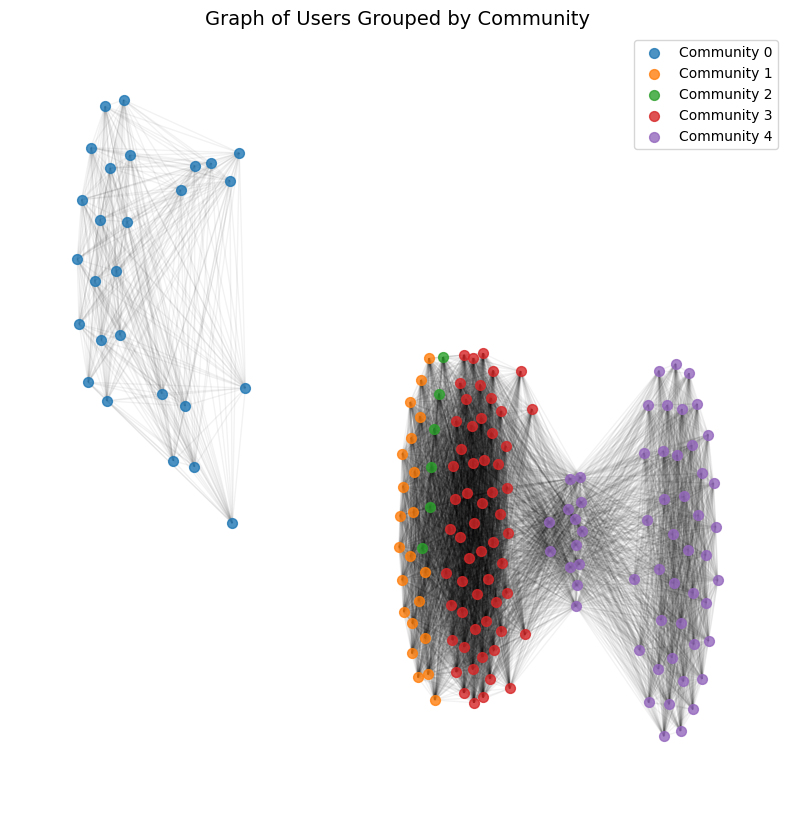

In [28]:
# nx used for plotting purposes
G = nx.Graph()
for comm_id, members in community_dict.items():
    for u, v in combinations(members, 2):
        G.add_edge(u, v, community=comm_id)

# assign community info to each node
community_map = {}
for comm_id, members in community_dict.items():
    for user in members:
        community_map[user] = comm_id


pos = nx.spring_layout(G, seed=42, k=0.5) 
communities = list(set(community_map.values()))
cmap = matplotlib.colormaps.get_cmap('tab10')

# draw nodes colored by community
plt.figure(figsize=(10, 10))
for i, comm in enumerate(communities):
    nodes = [n for n in G.nodes() if community_map[n] == comm]
    nx.draw_networkx_nodes(
        G, pos, nodelist=nodes, 
        node_color=[cmap(i)], 
        label=f"Community {comm}",
        node_size=50, alpha=0.8
    )

nx.draw_networkx_edges(G, pos, alpha=0.05)

plt.title("Graph of Users Grouped by Community", fontsize=14)
plt.axis('off')
plt.legend()
plt.show()

Description of communities:
* Community 0 - Users who almost exclusively play in contests. About 39% of users participated in NBA league bets; minimal participation in other sports league bets. No overlap between this community and others. 
* Community 1 - NBA participation ~90%, Conservative participation in contests with > 90% in Cnt6. Substantial overlap between this community and 2 and 3.
* Community 2 - All league participation. NBA participation ~100%, Conservative participation in contests with > 90% in Cnt6. Substantial overlap between this community and 1 and 3.
* Community 3 - All league participation. Moderate contributions across Cnt1–Cnt6, especially Cluster 6 (~80%). Semi-diverse contest participation. Substantial overlap between this community and 1, 2, and 4.
* Community 4 - All league participation. Most diverse contest participation. Heavy participation in Cnt1 (50/50 contests) at ~23%, much higher than other communities. And only ~50 participated in Cnt6 (other contests). Moderate overlap between this community and community 3.


(NOTE: Insights derived off saved notebook output. Running BigCLAM again with different random init could results in different community numbers, but same results. I.e community 0 being community 3 with a different init, but converge to overall same results.)

In [29]:
# view community descriptions 
for comm_id, group in df_communities.groupby('Community'):
    user_ids = group['UserID'].tolist()
    sub_df = small_df_playtype_ratio[small_df_playtype_ratio['UserID'].isin(user_ids)]
    summary = sub_df[['DidNBA', 'DidOth', 'Cnt1_Norm', 'Cnt2_Norm', 'Cnt3_Norm', 'Cnt4_Norm', 'Cnt5_Norm', 'Cnt6_Norm']].describe()
    print(f"Community {comm_id} Summary:\n", summary)

Community 0 Summary:
           DidNBA     DidOth  Cnt1_Norm  Cnt2_Norm  Cnt3_Norm  Cnt4_Norm  \
count  27.000000  27.000000  27.000000  27.000000  27.000000  27.000000   
mean    0.185185   0.185185   0.055324   0.092469   0.008987   0.017878   
std     0.395847   0.395847   0.113363   0.196485   0.018251   0.036451   
min     0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
25%     0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
50%     0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
75%     0.000000   0.000000   0.018868   0.000000   0.005221   0.014506   
max     1.000000   1.000000   0.393851   0.546875   0.062500   0.140625   

       Cnt5_Norm  Cnt6_Norm  
count  27.000000  27.000000  
mean    0.017988   0.807354  
std     0.032352   0.324342  
min     0.000000   0.125000  
25%     0.000000   0.883992  
50%     0.000000   0.944444  
75%     0.025411   1.000000  
max     0.153846   1.000000  
Community 1 Summary:
           

In [30]:
# get most representative users for analysis purposes
representative_users = {}
representative_rows = []

for comm_id, group in df_communities.groupby('Community'):
    user_ids = group['UserID'].tolist()
    sub_df = small_df_playtype_ratio[small_df_playtype_ratio['UserID'].isin(user_ids)]
    behavior_vectors = sub_df[['Cnt1_Norm', 'Cnt2_Norm', 'Cnt3_Norm', 'Cnt4_Norm', 'Cnt5_Norm', 'Cnt6_Norm']].values
    mean_vector = behavior_vectors.mean(axis=0).reshape(1, -1)
    sims = cosine_similarity_vect_matrix(behavior_vectors, mean_vector).flatten()

    best_idx = np.argmax(sims)
    most_representative_user = int(sub_df.iloc[best_idx]['UserID'])
    representative_users[comm_id] = most_representative_user

    rep_row = sub_df.iloc[best_idx].copy()
    rep_row['Community'] = comm_id
    representative_rows.append(rep_row)

    print(f"Community {comm_id} most representative user: {most_representative_user}")

Community 0 most representative user: 8239
Community 1 most representative user: 1393
Community 2 most representative user: 9444
Community 3 most representative user: 9444
Community 4 most representative user: 3692


In [31]:
# view most represntative users values
df_representatives = pd.DataFrame(representative_rows)
df_representatives = df_representatives.reset_index(drop=True).sort_values('Community')
df_representatives

,UserID,DidNBA,DidOth,Cnt1_Norm,Cnt2_Norm,Cnt3_Norm,Cnt4_Norm,Cnt5_Norm,Cnt6_Norm,Community
0,8239.0,0.0,0.0,0.074074,0.000000,0.000000,0.000000,0.000000,0.925926,0.0
1,1393.0,1.0,1.0,0.015915,0.007958,0.010610,0.031830,0.031830,0.901857,1.0
2,9444.0,1.0,1.0,0.032258,0.000000,0.019355,0.032258,0.064516,0.851613,2.0
3,9444.0,1.0,1.0,0.032258,0.000000,0.019355,0.032258,0.064516,0.851613,3.0
4,3692.0,1.0,1.0,0.224138,0.048851,0.048851,0.123563,0.057471,0.497126,4.0


### Cross-analysis

In [32]:
# create merged df on cluster and community assignments for users
merged_df = pd.merge(df_communities, df_cluster[['UserID', 'Cluster']], on='UserID', how='left')
merged_df.head()

,UserID,Community,Cluster
0,365,0,1
1,765,0,4
2,1447,0,3
3,1971,0,4
4,2555,0,1


In [33]:
cross_tab = pd.crosstab(merged_df['Community'], merged_df['Cluster'])
print(cross_tab)

Cluster     0  1   3   4  5
Community                  
0           1  4  20   2  0
1          45  4  23  11  1
2          41  3   9  13  1
3          44  4  10  12  1
4          34  7   5   9  0


In [34]:
# normalize
row_norm = cross_tab.div(cross_tab.sum(axis=1), axis=0)
col_norm = cross_tab.div(cross_tab.sum(axis=0), axis=1)

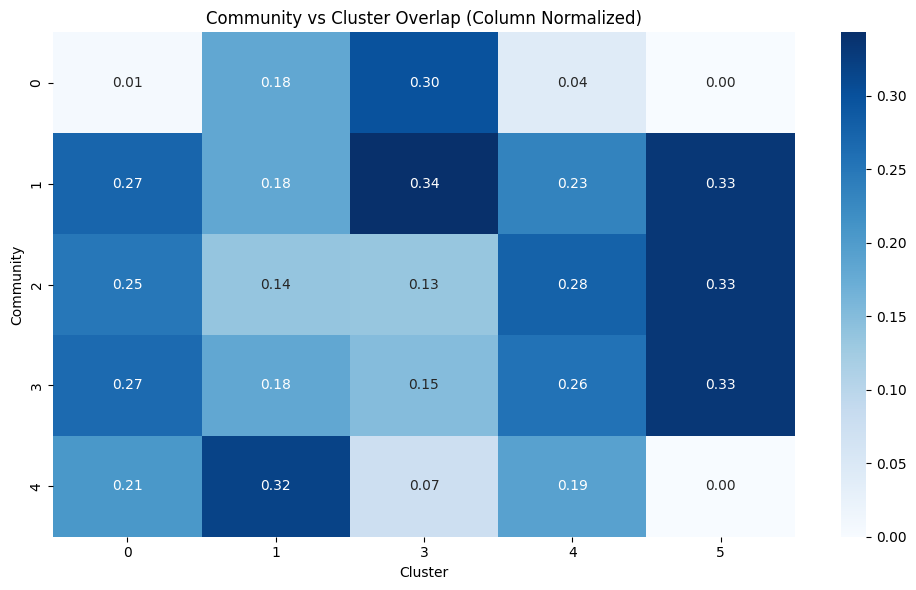

In [36]:
plt.figure(figsize=(10, 6))
sns.heatmap(col_norm, annot=True, fmt=".2f", cmap="Blues")
plt.title("Community vs Cluster Overlap (Column Normalized)")
plt.xlabel("Cluster")
plt.ylabel("Community")
plt.tight_layout()
plt.show()

Cross-analysis insights:
* Cluster 0 almost never having membership in community 0
* Cluster 1 having relatively strong membership in community 4
* Cluster 2 having no community membership due to no meeting the community membership strength threshold 
* Cluster 3 having relatively strong membership in community 1 and 0 as well as very weak membership in community 4 
* Cluster 4 almost never having membership in community 0
* Cluster 5 having membership spread equally among communities 1, 2, and 3

(NOTE: Insights derived off saved notebook output. Running BigCLAM again with different random init could results in different community numbers, but same results. I.e community 0 being community 3 with a different init, but should converege to same results. This is same note as above for community description)